# Web scraping with BeautifulSoup and Selenium

Prerequisites:

python 3.6
chromedriver <-- a Chrome browser engine to initialize Chrome for automated running of Selenium-related script

In [20]:
#Prerequisites

import requests  #for handling HTTP requests
from bs4 import BeautifulSoup  #for parsing HTML
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
import time
import pandas as pd

In [2]:
#Define website url which I am going to scrape
url = "https://www.ztore.com/en/category/all/jetso-zone/full-case-offer"
base_url = "https://www.ztore.com"

### We are expected to scrap a total of 464 product information from this page.

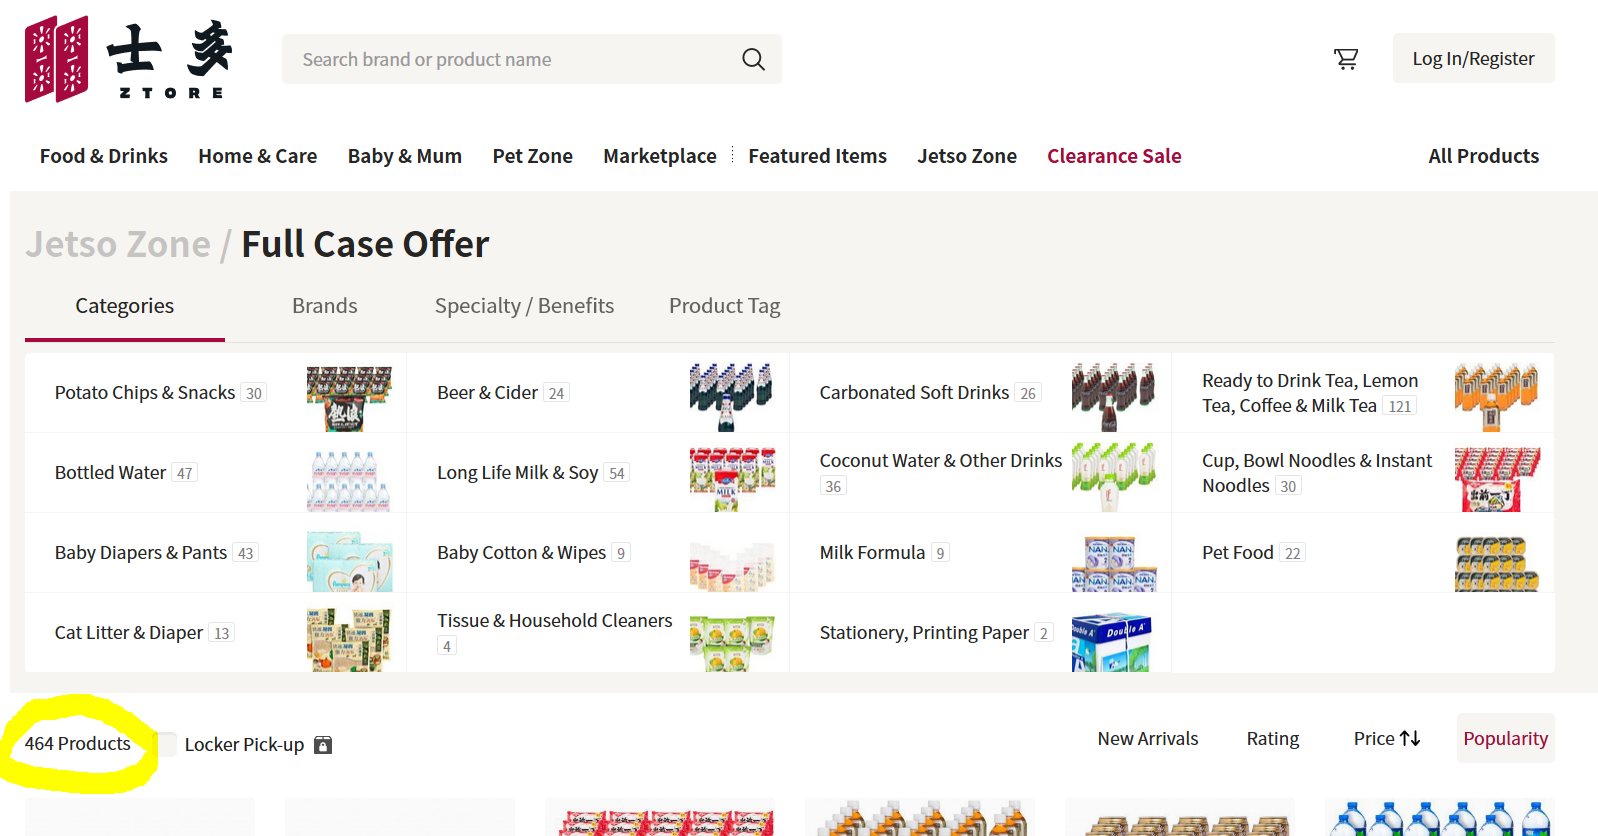

In [3]:
# create a new Chrome session
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(30) #tell WebDriver to elapse 30 seconds when trying to find any element (or elements) not immediately available
driver.get(url)

In [4]:
#After opening the url above, Selenium browser automator will search and click "viewAllButton" button
#to display more products. If no such button element, then ignore this exceptional case
try:
    python_button = driver.find_element_by_class_name('viewAllButton')
    python_button.click()#clicklink
except NoSuchElementException:
    print ("Note that there's no 'viewAllButton' in this page.")

In order to build and maintain an efficient automated web scraper, firstly we need to understand the structure of the website, e.g. html source code, XPath, etc.
(p.s. click F12 to inspect the element)

In [5]:
#Keep scrolling down page until display all products (URLs)

x = 48   #in ztore category page, the number of product display on screen before 'viewAllButton' is up to 48

while True:
    try:
        xpath = "//body/div[1]/div/div/div[3]/div[3]/div/div/div["
        #xpath of the last product shown in the display page
        #in case of error, try to replace with this xpath => "//body/div[1]/div/div/div[3]/div[2]/div/div/div["
        xpath += str(x)
        xpath += "]"
        element = driver.find_element_by_xpath(xpath)
        ActionChains(driver).move_to_element(element).perform()
        driver.execute_script("window.scrollBy(0, -150);")
        time.sleep(2)
        x+=10
        
    except NoSuchElementException:
        print ("There's no more products at the bottom of this page.")
        break

time.sleep(5)  #set browser to wait 5 seconds before executing next request

There's no more products at the bottom of this page.


In [6]:
#Gather all the category products URLs on the web page at once
food_containers = BeautifulSoup(driver.page_source, 'html.parser')
products_urls = [base_url + link.a.get('href') for link in food_containers.findAll("div", class_ = "jsx-1585925611 ProductItem")]

print("We finally fetched " + str(len(products_urls)) + " products URLs.")

We finally fetched 470 products URLs.


In [7]:
#Take a look into the first 5 scraped product urls:
products_urls[:5]

['https://www.ztore.com/en/product/water-dispenser-with-distilled-water-6000220-c1174',
 'https://www.ztore.com/en/product/water-dispenser-with-distilled-water-white-6000230-c1174',
 'https://www.ztore.com/en/product/instant-noodle-sesame-oil-8000117-c1174',
 'https://www.ztore.com/en/product/oolong-tea-8000143-c1174',
 'https://www.ztore.com/en/product/rtd-coffee-with-milk-sugar-8000146-c1174']

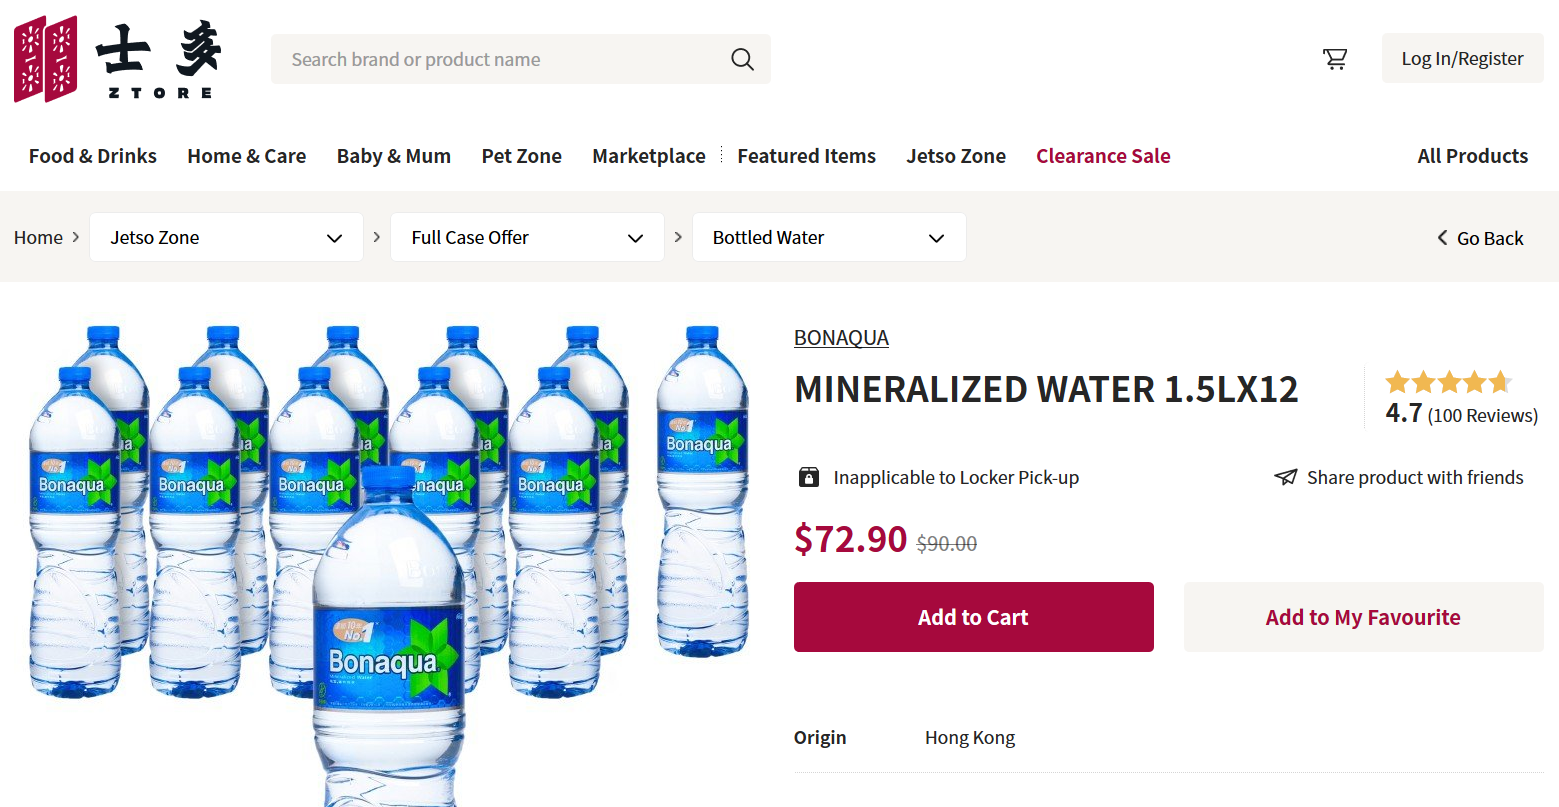

### We would like to retrieve product details from each product page url, including:
#### - Brand name
#### - Main Category
#### - Sub-category
#### - Product Name
#### - Country of origin
#### - Number of reviews
#### - Rating score (0 - 5)
#### - Price  <- original price/ promotional price (if any)
#### - Main image url

In [8]:
#Define field of product details
brand = []
main_cat = []  #main category
sub_cat = []   #sub category
product_name = []
country_of_origin = []
rating = []    #rating score (0-5)
rating_count = []   #number of reviews
price = []  
img_url = []

In [9]:
#Define a function to request and parse a HTML web page
def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

In [10]:
%%time
#Scrape data from every product URL:
#Set browser to wait 3 seconds each time before sending new request to avoid overloading of website

for url in products_urls:
    soup = getAndParseURL(url)
    
    #brand
    for link in soup.find("div", class_ = "jsx-923637705 brand"):
        brand.append(link.string)
        time.sleep(3)
    
    #main category
    main_cat.append(soup.findAll(type = 'text')[1]['value'])
    
    #sub-category
    sub_cat.append(soup.findAll(type = 'text')[2]['value'])
    
    #product name
    product_name.append(soup.find("div", class_ = "jsx-923637705 name").text)
    time.sleep(3)
    
    #country of origin
    country_of_origin.append(soup.find("div", class_ = "jsx-923637705 info-row-country").text)
    time.sleep(3)
    
    #rating
    rating.append(soup.find("span", {"class": "jsx-923637705 rating"}).text.strip())
    time.sleep(3)
    
    #rating_count (number of reviews)
    rating_count.append(soup.find("span", {"class": "jsx-923637705 rating-count"}).text[1:-9])
    time.sleep(3)
    
    #price (original/promotion price w/o '$' sign)
    #get promotional price if any, otherwise get original price
    try:
        price.append(soup.find("span", {"class": "jsx-923637705 promotion"}).text[1:])
        time.sleep(3)
    except AttributeError:
        price.append(soup.find("div", {"class": "jsx-923637705 price"}).text[1:])
        time.sleep(3)
    
    #main image url
    for link in soup.find("div", class_ = "jsx-462475733 product-image-wrapper"):
        img_url.append(link.find('img')['src'])
        time.sleep(3)

print ("Scraping is completed.")

Scraping is completed.
Wall time: 2h 54min 58s


In [11]:
#Close the browser session
driver.quit()

In [12]:
#Remove redundant image urls (ending with '.svg') before loading data to dataframe
svg_count = 0

for link in img_url:
    if link.endswith(".svg"):
        img_url.remove(link)
        svg_count+=1
        
print("Removed " + str(svg_count) + " image urls.")

Removed 12 image urls.


In [13]:
#Create a dataframe with scraped data
scraped_data = pd.DataFrame({'brand': brand,
                             'main_category': main_cat,
                             'sub_category': sub_cat,                          
                             'product_name': product_name,
                             'country_of_origin': country_of_origin,
                             "rating": rating,
                             "number_of_reviews": rating_count,
                             "price": price,
                             "img_url": img_url
                             }, columns=['brand', 'main_category','sub_category', 'product_name',
                                         'country_of_origin', 'rating', 'number_of_reviews', 
                                         'price', 'img_url'])

In [14]:
#Check if any missing values inside each dataframe column
#scraped_data.isnull().sum().sort_values(ascending=False)

In [15]:
#Basic data wrangling
scraped_data['rating'] = scraped_data['rating'].replace("", 0)   #replace null rating score with 0
scraped_data['product_name'] = scraped_data['product_name'].replace("xa0", "")   #for cleaning messy product name
scraped_data.drop_duplicates(keep='first', inplace=True)   #remove duplicated row record(s) if any

In [16]:
#Check dataframe structure
scraped_data.head()

,brand,main_category,sub_category,product_name,country_of_origin,rating,number_of_reviews,price,img_url
0,WATSONS,Water,Distilled Water,WATER DISPENSER WITH DISTILLED WATER (BLACK) SET,Multiple,4.5,51,488.00,https://cdn.ztore.com/images/ztore/production/...
1,WATSONS,Water,Distilled Water,WATER DISPENSER WITH DISTILLED WATER (WHITE) SET,Multiple,4.3,33,488.00,https://cdn.ztore.com/images/ztore/production/...
2,DE-MA-E,Noodle & Pasta,Instant Noodle-Japanese,INSTANT NOODLE-SESAME OIL 100GX30,Hong Kong,4.8,120,92.90,https://cdn.ztore.com/images/ztore/production/...
3,ROBIFF,RTD -Tea & Lemon Tea,"PET-Green Tea, Red Tea and Fruit Tea",OOLONG TEA 500MLX24,China,4.8,994,145.00,https://cdn.ztore.com/images/ztore/production/...
4,NESCAFE,RTD-Coffee & Milk Tea,Coffee,RTD COFFEE WITH MILK & SUGAR-CASE 250MLX24,China,4.8,862,128.00,https://cdn.ztore.com/images/ztore/production/...


In [17]:
#Check if still any missing values inside each dataframe column
scraped_data.isnull().sum().sort_values(ascending=False)

img_url              0
price                0
number_of_reviews    0
rating               0
country_of_origin    0
product_name         0
sub_category         0
main_category        0
brand                0
dtype: int64

In [18]:
#Export data to csv
scraped_data.to_csv('scraped_ztore_product_data.csv', index = False)

In [21]:
#wrap up scraping result
print("Totally scraped " + str(len(scraped_data.index)) + " products.")
print("Done!")

Totally scraped 464 products.
Done!


## Wrap up
Web scraping can be seen as a data collection exercise. In the above example, I have retrieved a total of 464 full case products information from specific product page in Ztore. During the process, our crawler should always be 'polite' to the website by adhering to robots.txt protocol.

For me, one of the most awkward parts was to identify the website scrolling behavior. In Ztore case, it is necessary for crawler to scroll page infinitely in order to fetch all product urls. Therefore, I have made some tricky steps to simulate human-like actions in the Selenium browser session so that the next page element could be called continously.

After data collection and prelim data cleaning (a.k.a. data preprocessing), we can move to Exploratory Data Analysis (EDA) to uncover characteristic of our data.